In [4]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import constants 
####################
# Choose a context #
####################
context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')
buf = context.new_buffer()

#references: https://www.sciencedirect.com/science/article/pii/S0168900222011445?ref=pdf_download&fr=RR-2&rr=80ca25af8a5ace93

# Ion properties:
m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
A = 16 # Weight of O
#Z = 6  # Number of protons in the ion (O)
#m_e = 0.511e6 # eV/c^2 -- electron mass
m_p = 938.272088e6 # eV/c^2 -- proton mass
clight = 299792458.0 # m/s

q0=5

mass0 = A*m_u #+ Ne*m_e # eV/c^2

beta_rel = 0.64
gamma_rel = 1.30

p0c = mass0*beta_rel*gamma_rel #eV/c

# equiv_proton_momentum = 236e9 # eV/c = gamma_p*m_p*v
# gamma_p = np.sqrt( 1 + (equiv_proton_momentum/m_p)**2 ) # equvalent gamma for protons in the ring

# p0c = equiv_proton_momentum*(Z-Ne) # eV/c
gamma2 = np.sqrt( 1 + (p0c/mass0)**2 ) # ion relativistic factor
beta2 = np.sqrt(1-1/(gamma2*gamma2)) # ion beta

print(gamma2)
print(beta2)


1.3008551033839242
0.639579302749178


In [5]:
p0c

12400049491.415041

In [6]:
circumference =  128.80 #m
T = circumference/(clight*beta_rel)
s_per_turn = T
slip_factor=0.45

beta_x = 6
beta_y = 2

disp_x = 0
Q_x = 2.2
Q_y = 2.4
dQx = 0
dQy = 0

arc = xt.LineSegmentMap(
        qx=Q_x, qy=Q_y,
        dqx=dQx, dqy=dQy,
        length=circumference,
        betx=beta_x,
        bety=beta_y
        )

In [7]:
np.linspace(1, 10, 10, endpoint=True, dtype=int)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [8]:
#laser_radius_list = np.linspace(1, 40, 16, endpoint=True, dtype=int)
laser_radius_list = np.linspace(1, 10, 10, endpoint=True, dtype=int)
# laser_radius_list = np.linspace(20, 40, 8, endpoint=True, dtype=int)
# laser_radius_list = np.linspace(23, 43, 8, endpoint=True, dtype=int)
laser_radius_list = laser_radius_list * 1e-3



for laser_radius in tqdm(laser_radius_list):

    emittance_x=10*1e-6 #inital emittance
    emittance_y=15*1e-6 #inital emittance
    num_particles = int(1e4)

    sigma_x = np.sqrt(beta_x*emittance_x)
    sigma_px = np.sqrt(emittance_x*1/beta_x)
    sigma_y = np.sqrt(beta_y*emittance_y)
    sigma_py = np.sqrt(emittance_y*1/beta_y)
    sigma_p = 2e-5 # relative ion momentum spread
    sigma_p = 2e-4 # relative ion momentum spread

    delta = np.random.uniform(low=0.45e-4, high=0.65e-4, size=num_particles)
    delta = np.random.uniform(low=0e-4, high=1e-4, size=num_particles)
    delta = np.linspace(0e-4, 1e-4, num_particles)
    delta = np.linspace(-9.2e-5, 9.2e-5, num_particles)


    # delta = np.random.normal(loc=0, scale=sigma_p, size=num_particles)
    x = np.random.normal(loc=0.0, scale=sigma_x, size=num_particles) + disp_x * delta
    px = np.random.normal(loc=0.0, scale=sigma_px, size=num_particles)
    y = np.random.normal(loc=0.0, scale=sigma_y, size=num_particles)
    py = np.random.normal(loc=0.0, scale=sigma_py, size=num_particles)

    particles = xp.Particles(
        mass0=mass0,
        p0c=p0c,
        q0=q0,
        x=x,
        px=px,
        y=y,
        py=py,
        delta=delta,
        zeta=0
    )

    ##################
    # Laser Cooler #
    ##################

    #laser-ion beam collision angle
    theta_l = 2.6*np.pi/180 # rad
    theta_l = 0
    nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

    # Ion excitation energy:
    # hw0 = 230.823 # eV
    hc=constants.hbar*clight/constants.e # eV*m (ħc)
    lambda_0 = 103.76*1e-9 # m -- ion excitation wavelength
    hw0 = 2*np.pi*hc/lambda_0 # m -- ion excitation wavelength
    ion_excited_lifetime=2.44e-9


    lambda_l = lambda_0*gamma_rel*(1 + beta_rel*np.cos(theta_l)) # m -- laser wavelength
    # Shift laser wavelength for fast longitudinal cooling:
    #lambda_l = lambda_l*(1+3*sigma_p)
    #lambda_l = lambda_l*(1+2.5*sigma_p)
    lambda_l = 2.2131631631631633e-07
    lambda_l = 2.213116311631163e-07
    lambda_l = 2.2130563056305633e-07 #target 5e-6
    #lambda_l = lambda_l*(1+1*sigma_p) # m

    laser_frequency = clight/lambda_l # Hz


    print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))
    print('Laser wavelength = %.20f nm' % (lambda_l/1e-9))

    # laser_waist_radius = 5*1e-3
    # laser_waist_radius = 1000*1e-3

    laser_power=40*1e-3 #W
    laser_waist_radius = laser_radius
    laser_area=np.pi*(laser_waist_radius*laser_waist_radius)

    # laser_waist_radius = 1000*1e-3
    # laser_intensity=200000
    # laser_intensity=12732.395447351628
    laser_intensity=laser_power/laser_area

    cooling_section_length=25
    GF_IP = xt.CWLaser(_buffer=buf,
                        laser_x=0,
                        laser_y=0,
                        laser_z=0,
                        
                        laser_direction_nx = 0,
                        laser_direction_ny = 0,
                        laser_direction_nz = -1,
                        laser_wavelength = lambda_l, # m
                        laser_waist_radius = laser_waist_radius, # m
                        laser_intensity=laser_intensity,
                        ion_excitation_energy = hw0, # eV
                        ion_excited_lifetime  = ion_excited_lifetime, # sec
                        cooling_section_length=cooling_section_length
                            
    )


    # ##################
    # # Tracking #
    # ##################
    # x, px,y,py, zeta,accumulated_length,excited_list,delta_list,state_list= [], [],[],[], [], [], [],[],[]
    # num_turns = int(103.6*1e6) #Lanzhou turns = 103.6*1e6
    # save_interval=num_turns/1000
    # # loop over turns
    # for i in tqdm(range(num_turns)):
    #     if i % save_interval ==0:
        
    #         x.append(particles.x.copy())
    #         px.append(particles.px.copy())
    #         x.append(particles.y.copy())
    #         py.append(particles.py.copy())
    #         # zeta.append(particles.zeta)
    #         # accumulated_length.append(particles.s)

    #         state=particles.state.copy()
    #         state_list.append(state)

    #         excited=particles.state==2
    #         fraction_excitation = sum(excited)/len(excited)

    #         excited_list.append(excited)

    #         delta_list.append(particles.delta.copy())
        
    #     # track particle
    #     arc.track(particles)
    #     GF_IP.track(particles)

    #tracker=xt.Tracker(_context=context, _buffer=buf, line=line,reset_s_at_end_turn=False)

    # simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
    max_time_s = 0.02
    int_time_s = 0.001
    T_per_turn = circumference/(clight*beta_rel)
    num_turns = int(max_time_s/T_per_turn)
    save_interval = int(int_time_s/T_per_turn)

    num_turns = int(103.6*1e6)
    save_interval=num_turns/100

    # create a monitor object, to reduce holded data
    monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                  n_repetitions=int(num_turns/save_interval),
                                  repetition_period=save_interval,
                                  num_particles=num_particles)

    line = xt.Line(
            elements=[monitor,GF_IP, arc])

    line.particle_ref = xp.Particles(mass0=mass0, q0=q0, p0c=p0c)
    #line.build_tracker(_context=context,reset_s_at_end_turn=False)


    tracker=xt.Tracker(_context=context, _buffer=buf, line=line)

    line.track(particles, num_turns=num_turns,
                  turn_by_turn_monitor=False,with_progress=True)

    # extract relevant values
    x = monitor.x[:,:,0]
    px = monitor.px[:,:,0]
    y = monitor.y[:,:,0]
    py = monitor.py[:,:,0]
    delta = monitor.delta[:,:,0]
    zeta = monitor.zeta[:,:,0]
    accumulated_length=monitor.s[:,:,0]
    state = monitor.state[:,:,0]
    time = monitor.at_turn[:, 0, 0] * T_per_turn

    excited=particles.state==2
    excited = excited.astype(int)
    fraction_excitation = sum(excited)/len(excited)
    time = np.arange(0, num_turns, save_interval) * s_per_turn

    #np.savez(f'results/langzhou_data({laser_waist_radius*1e3}mm).npz', x=x, px=px, y=y, py=py,zeta=zeta, delta=delta_list, excited=excited_list,time=time)
    np.savez(f'results/radii2024/{laser_waist_radius*1e3}.npz', x=x, px=px, y=y, py=py,zeta=zeta, delta=delta, excited=excited,time=time)

  0%|          | 0/10 [00:00<?, ?it/s]

Laser wavelength = 221.31 nm
Laser wavelength = 221.30563056305632585463 nm
Compiling ContextCpu kernels...


4b080e93b0d047e8b7d43a9e51fdf9c6.c: In function ‘CWLaser_track_local_particle’:
4b080e93b0d047e8b7d43a9e51fdf9c6.c:3525:16: warning: unused variable ‘DeltaDetuningTau’ [-Wunused-variable]
         double DeltaDetuningTau = DeltaDetuning/(2.0*gamma);
                ^~~~~~~~~~~~~~~~


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/103600000 [00:00<?, ?it/s]

 10%|█         | 1/10 [16:49:50<151:28:38, 60590.89s/it]

Laser wavelength = 221.31 nm
Laser wavelength = 221.30563056305632585463 nm
Compiling ContextCpu kernels...


faa684a245ba48fc891d7c7bbd137479.c: In function ‘CWLaser_track_local_particle’:
faa684a245ba48fc891d7c7bbd137479.c:3525:16: warning: unused variable ‘DeltaDetuningTau’ [-Wunused-variable]
         double DeltaDetuningTau = DeltaDetuning/(2.0*gamma);
                ^~~~~~~~~~~~~~~~


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/103600000 [00:00<?, ?it/s]

 20%|██        | 2/10 [33:38:10<134:31:35, 60536.97s/it]

Laser wavelength = 221.31 nm
Laser wavelength = 221.30563056305632585463 nm
Compiling ContextCpu kernels...


2e3b768d44a04526ab7a45a8e447e8c9.c: In function ‘CWLaser_track_local_particle’:
2e3b768d44a04526ab7a45a8e447e8c9.c:3525:16: warning: unused variable ‘DeltaDetuningTau’ [-Wunused-variable]
         double DeltaDetuningTau = DeltaDetuning/(2.0*gamma);
                ^~~~~~~~~~~~~~~~


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/103600000 [00:00<?, ?it/s]

 30%|███       | 3/10 [50:53:23<119:06:38, 61256.97s/it]

Laser wavelength = 221.31 nm
Laser wavelength = 221.30563056305632585463 nm
Compiling ContextCpu kernels...


40c5efe92061488a8f9631a8b705e827.c: In function ‘CWLaser_track_local_particle’:
40c5efe92061488a8f9631a8b705e827.c:3525:16: warning: unused variable ‘DeltaDetuningTau’ [-Wunused-variable]
         double DeltaDetuningTau = DeltaDetuning/(2.0*gamma);
                ^~~~~~~~~~~~~~~~


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/103600000 [00:00<?, ?it/s]

 40%|████      | 4/10 [68:53:27<104:25:43, 62657.17s/it]

Laser wavelength = 221.31 nm
Laser wavelength = 221.30563056305632585463 nm
Compiling ContextCpu kernels...


e082d1176475423e932de99e5410430d.c: In function ‘CWLaser_track_local_particle’:
e082d1176475423e932de99e5410430d.c:3525:16: warning: unused variable ‘DeltaDetuningTau’ [-Wunused-variable]
         double DeltaDetuningTau = DeltaDetuning/(2.0*gamma);
                ^~~~~~~~~~~~~~~~


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/103600000 [00:00<?, ?it/s]

 50%|█████     | 5/10 [88:02:20<90:10:00, 64920.15s/it] 

Laser wavelength = 221.31 nm
Laser wavelength = 221.30563056305632585463 nm
Compiling ContextCpu kernels...


3162957a3b694b0fa893df33c23a5ad1.c: In function ‘CWLaser_track_local_particle’:
3162957a3b694b0fa893df33c23a5ad1.c:3525:16: warning: unused variable ‘DeltaDetuningTau’ [-Wunused-variable]
         double DeltaDetuningTau = DeltaDetuning/(2.0*gamma);
                ^~~~~~~~~~~~~~~~


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/103600000 [00:00<?, ?it/s]

 60%|██████    | 6/10 [108:34:09<75:31:45, 67976.31s/it]

Laser wavelength = 221.31 nm
Laser wavelength = 221.30563056305632585463 nm
Compiling ContextCpu kernels...


8fe1c282968144719d40a5fc7d7c42f8.c: In function ‘CWLaser_track_local_particle’:
8fe1c282968144719d40a5fc7d7c42f8.c:3525:16: warning: unused variable ‘DeltaDetuningTau’ [-Wunused-variable]
         double DeltaDetuningTau = DeltaDetuning/(2.0*gamma);
                ^~~~~~~~~~~~~~~~


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/103600000 [00:00<?, ?it/s]

 70%|███████   | 7/10 [130:33:05<59:41:14, 71624.96s/it]

Laser wavelength = 221.31 nm
Laser wavelength = 221.30563056305632585463 nm
Compiling ContextCpu kernels...


eeb14892616b4f4381c2b82b81684b7a.c: In function ‘CWLaser_track_local_particle’:
eeb14892616b4f4381c2b82b81684b7a.c:3525:16: warning: unused variable ‘DeltaDetuningTau’ [-Wunused-variable]
         double DeltaDetuningTau = DeltaDetuning/(2.0*gamma);
                ^~~~~~~~~~~~~~~~


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/103600000 [00:00<?, ?it/s]

 80%|████████  | 8/10 [153:27:43<41:42:39, 75079.86s/it]

Laser wavelength = 221.31 nm
Laser wavelength = 221.30563056305632585463 nm
Compiling ContextCpu kernels...


3918214fe1514c81b6fe00cd79d8ff8c.c: In function ‘CWLaser_track_local_particle’:
3918214fe1514c81b6fe00cd79d8ff8c.c:3525:16: warning: unused variable ‘DeltaDetuningTau’ [-Wunused-variable]
         double DeltaDetuningTau = DeltaDetuning/(2.0*gamma);
                ^~~~~~~~~~~~~~~~


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/103600000 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [176:31:09<21:32:37, 77557.72s/it]

Laser wavelength = 221.31 nm
Laser wavelength = 221.30563056305632585463 nm
Compiling ContextCpu kernels...


aca20e93bb7841b7abe24b538bba8dcc.c: In function ‘CWLaser_track_local_particle’:
aca20e93bb7841b7abe24b538bba8dcc.c:3525:16: warning: unused variable ‘DeltaDetuningTau’ [-Wunused-variable]
         double DeltaDetuningTau = DeltaDetuning/(2.0*gamma);
                ^~~~~~~~~~~~~~~~


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/103600000 [00:00<?, ?it/s]

100%|██████████| 10/10 [199:16:11<00:00, 71737.16s/it]  


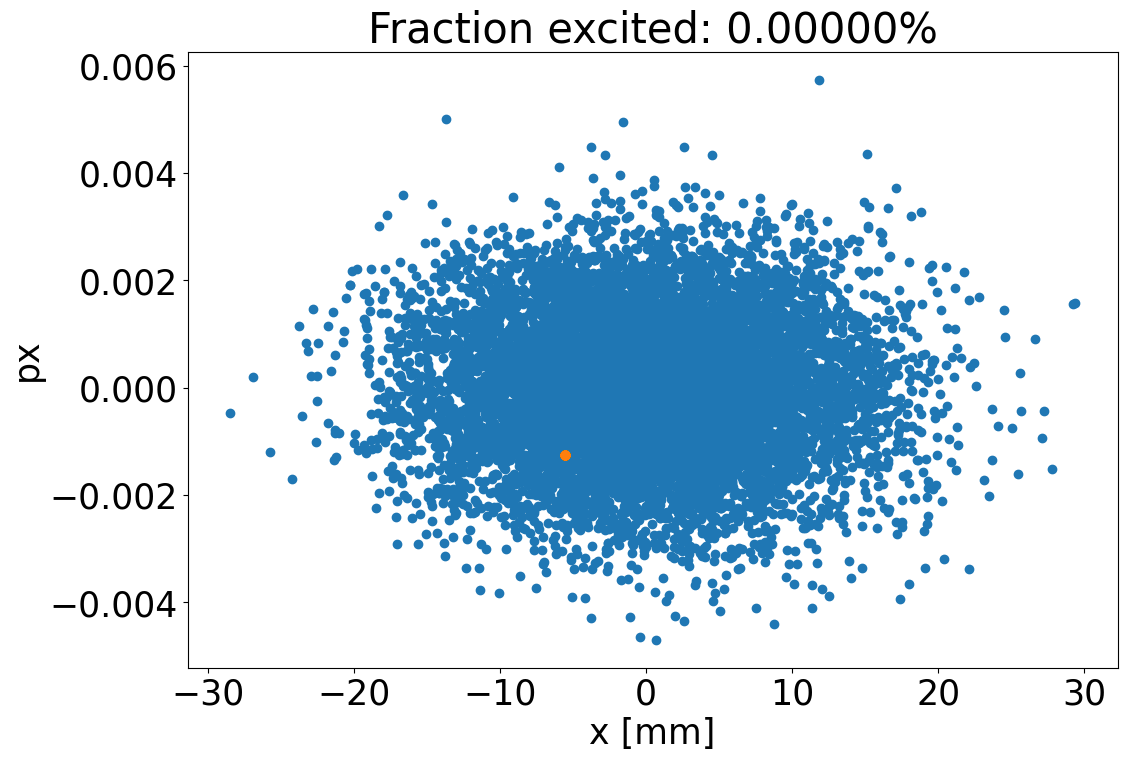

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})

# Assuming 'fraction_excitation' is a variable that stores the fraction excited
plt.title(f'Fraction excited: {fraction_excitation*100:.5f}%')

# Other plotting commands
# plt.axvline(laser_x,color='red')
# plt.axvline(laser_x+laser_waist_radius,color='red')
# plt.axvline(laser_x-laser_waist_radius,color='red')

plt.scatter(particles.x*1e3, particles.px)
plt.scatter(particles.x[excited]*1e3, particles.px[excited])
plt.xlabel('x [mm]')
plt.ylabel('px')
plt.show()

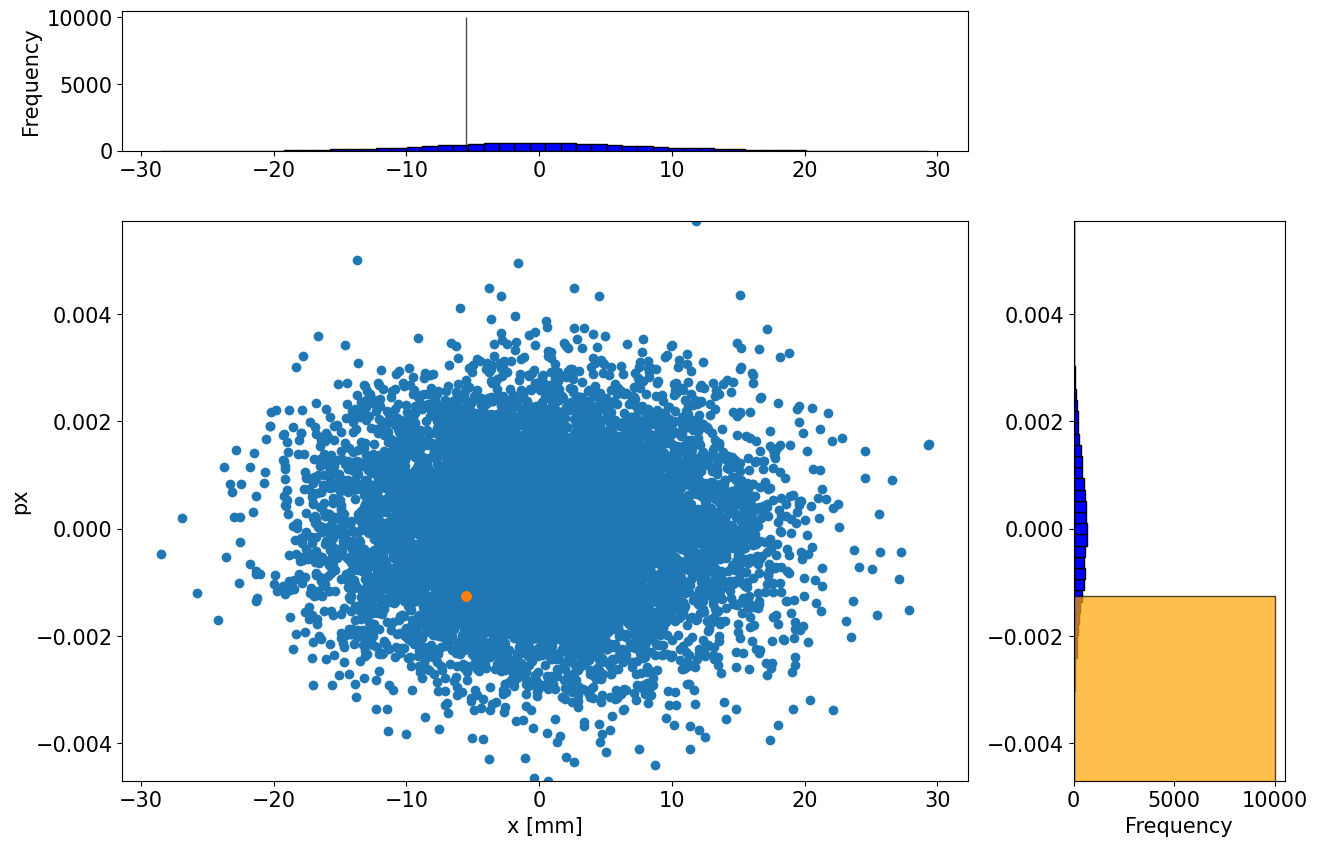

In [10]:
import matplotlib.pyplot as plt

# Assuming 'fraction_excitation' is a variable that stores the fraction excited
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 15})

# Create a 2x2 grid of subplots
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)

# Main scatter plot
ax_main = plt.subplot(grid[1:, 0:3])
ax_main.scatter(particles.x * 1e3, particles.px)
ax_main.scatter(particles.x[excited] * 1e3, particles.px[excited])
ax_main.set_xlabel('x [mm]')
ax_main.set_ylabel('px')
ax_main.set_ylim(bottom=min(particles.px), top=max(particles.px))  # Set y-axis limits

# Histogram along the x-axis
ax_histx = plt.subplot(grid[0, 0:3], sharex=ax_main)
ax_histx.hist(particles.x * 1e3, bins=50, color='blue', edgecolor='black')
ax_histx.hist(particles.x[excited] * 1e3, bins=50, color='orange', edgecolor='black', alpha=0.7)
ax_histx.set_ylabel('Frequency')

# Histogram along the y-axis
ax_histy = plt.subplot(grid[1:, 3], sharey=ax_main)
ax_histy.hist(particles.px, bins=50, orientation='horizontal', color='blue', edgecolor='black')
ax_histy.hist(particles.px[excited], bins=50, orientation='horizontal', color='orange', edgecolor='black', alpha=0.7)
ax_histy.set_xlabel('Frequency')
ax_histy.set_ylim(bottom=min(particles.px), top=max(particles.px))  # Set y-axis limits

plt.show()


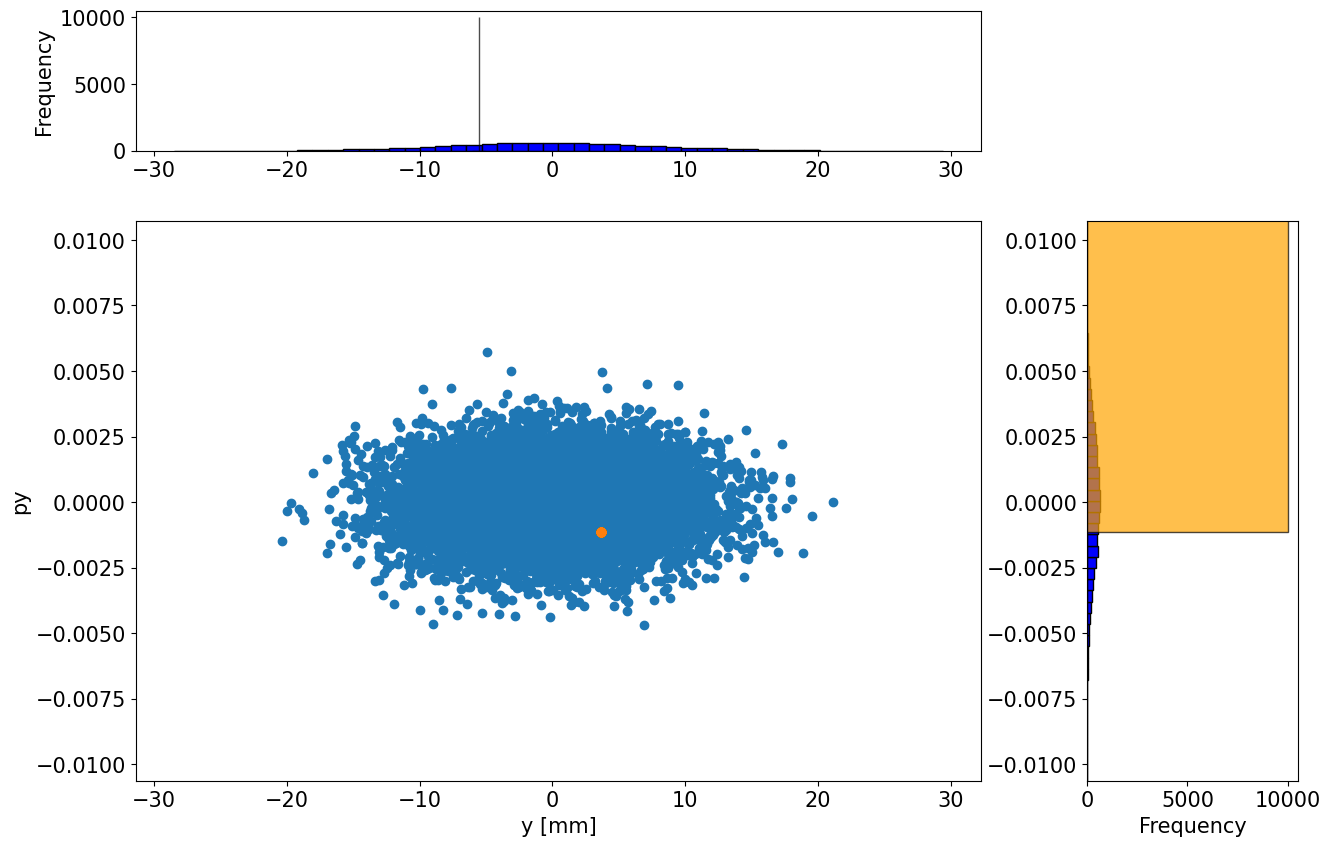

In [11]:
import matplotlib.pyplot as plt

# Assuming 'fraction_excitation' is a variable that stores the fraction excited
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 15})

# Create a 2x2 grid of subplots
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)

# Main scatter plot
ax_main = plt.subplot(grid[1:, 0:3])
ax_main.scatter(particles.y * 1e3, particles.px)
ax_main.scatter(particles.y[excited] * 1e3, particles.py[excited])
ax_main.set_xlabel('y [mm]')
ax_main.set_ylabel('py')
ax_main.set_ylim(bottom=min(particles.px), top=max(particles.px))  # Set y-axis limits

# Histogram along the x-axis
ax_histx = plt.subplot(grid[0, 0:3], sharex=ax_main)
ax_histx.hist(particles.x * 1e3, bins=50, color='blue', edgecolor='black')
ax_histx.hist(particles.x[excited] * 1e3, bins=50, color='orange', edgecolor='black', alpha=0.7)
ax_histx.set_ylabel('Frequency')

# Histogram along the y-axis
ax_histy = plt.subplot(grid[1:, 3], sharey=ax_main)
ax_histy.hist(particles.py, bins=50, orientation='horizontal', color='blue', edgecolor='black')
ax_histy.hist(particles.py[excited], bins=50, orientation='horizontal', color='orange', edgecolor='black', alpha=0.7)
ax_histy.set_xlabel('Frequency')
ax_histy.set_ylim(bottom=min(particles.py), top=max(particles.py))  # Set y-axis limits

plt.show()

<Figure size 640x480 with 0 Axes>

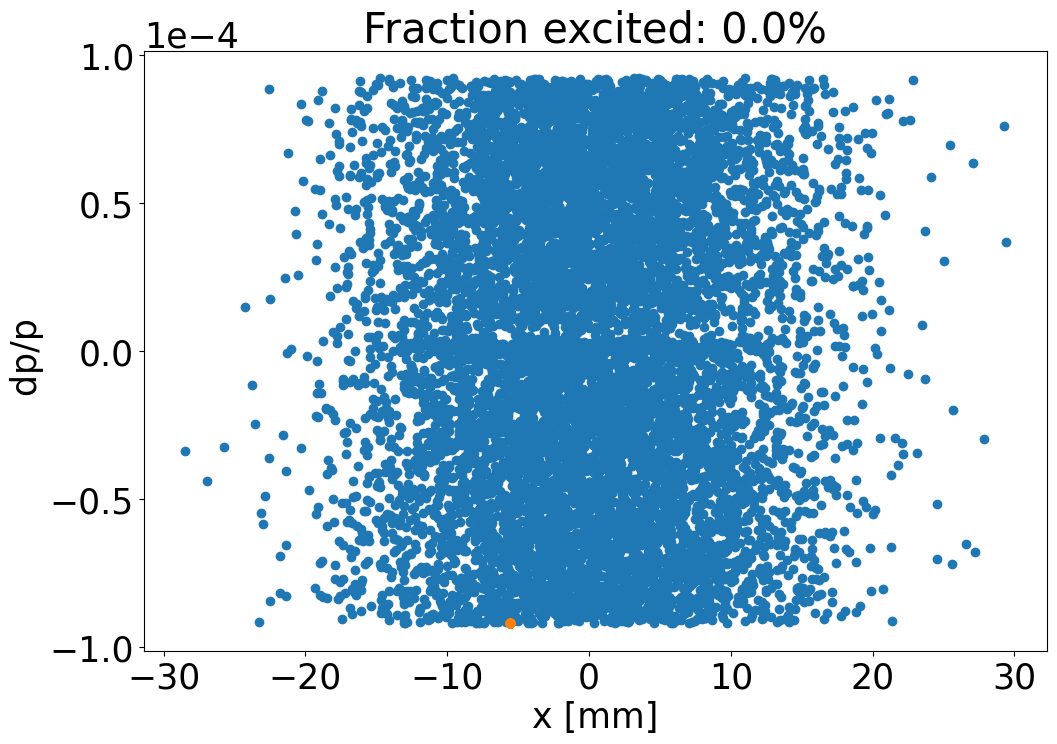

In [12]:
plt.figure()
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction excited: {round(fraction_excitation*100, 5)}%')

#plt.axvline(laser_x,color='red')
# plt.axvline(laser_x+laser_waist_radius,color='red')
# plt.axvline(laser_x-laser_waist_radius,color='red')

plt.scatter(particles.x*1e3,particles.delta)
plt.scatter(particles.x[excited]*1e3,particles.delta[excited])
plt.xlabel('x [mm]')
plt.ylabel('dp/p ')
plt.tight_layout()

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.savefig('First_turn.eps', format='eps', dpi=300)
plt.show()